#Prepare

In [1]:
import pandas as pd

In [2]:
!pip install -U pycld2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.4 MB 1.3 MB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9834163 sha256=c48923185898430e3780d3a109ff012169a9a7ed92256dbdc4e680c48e4699a6
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614
Successfully built pycld2


In [3]:
import pycld2 as cld2

In [4]:
from PIL import Image, ImageFont, ImageDraw 
import json


englishBeneFont = ImageFont.truetype('/content/drive/MyDrive/plaqueGen/Roboto-Black.ttf', 80)
englishSponsorFont = ImageFont.truetype('/content/drive/MyDrive/plaqueGen/Roboto-Black.ttf', 60)
tradChnBeneFont=ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSansTC-Regular.otf', 80)
tradChnSponsorFont=ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSansTC-Regular.otf', 60)
simpChnBeneFont=ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSansSC-Regular.otf', 80)
simpChnSponsorFont=ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSansSC-Regular.otf', 60)
koreanBeneFont=ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSansKR-Regular.otf', 80)
koreanSponsorFont=ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSansKR-Regular.otf', 60)
vietBeneFont=ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSansKR-Regular.otf', 80)
vietSponsorFont=ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSansKR-Regular.otf', 45)
idFont = ImageFont.truetype('/content/drive/MyDrive/plaqueGen/Roboto-Black.ttf', 30)

def adapter(beneText, sponsorText, plaqueTypeText, plaqueIdNum):
  if beneText.isascii() == False:
    isReliable, textBytesFound, details = cld2.detect(beneText)
    beneTextLang=details[0][1]
    
    if beneTextLang == 'ko':
      beneTextFont=koreanBeneFont
    elif beneTextLang=='vi':
      beneTextFont=vietBeneFont
    elif beneTextLang=='zh':
      beneTextFont=simpChnBeneFont
    elif beneTextLang=='zh-Hant':
      beneTextFont=tradChnBeneFont
    else:
      return False, {}
  else:
    beneTextFont=englishBeneFont
    beneTextLang="en"

  if sponsorText==beneText:
    sponsorText=""

  if sponsorText.isascii() == False:
    isReliable, textBytesFound, details = cld2.detect(sponsorText)
    sponsorTextLang=details[0][1]

    if sponsorTextLang == 'ko':
      sponsorTextFont=koreanBeneFont
    elif sponsorTextLang=='vi':
      sponsorTextFont=vietBeneFont
    elif sponsorTextLang=='zh':
      sponsorTextFont=simpChnBeneFont
    elif sponsorTextLang=='zh-Hant':
      sponsorTextFont=tradChnBeneFont
    else:
      return False, {}
  else:
    sponsorTextFont=englishSponsorFont
    sponsorTextLang="en"
  
  if "MMB" in plaqueTypeText:
    plaqueType="mmb"
  elif "Rebirth" in plaqueTypeText:
    plaqueType="rebirth"
  else:
    return False, {}

  plaqueId=str.format("ChanQi{0:04}", plaqueIdNum)

  return True, {
"beneText":beneText, 
"beneTextFont":beneTextFont, 
"beneTextLang":beneTextLang,
"sponsorText":sponsorText, 
"sponsorTextFont":sponsorTextFont,
"sponsorTextLang":sponsorTextLang, 
"plaqueId":plaqueId, 
"plaqueIdFont":idFont, 
"plaqueType":plaqueType      
  }


def genPlaque(beneText, beneTextFont, beneTextLang, 
              sponsorText, sponsorTextFont, sponsorTextLang,
              plaqueId, plaqueIdFont, 
              plaqueType):
  if beneText in ['zh', 'zh-Hant', 'ko']:
    beneText='\n'.join(beneText)

  if plaqueType=="mmb":
    templatePath="/content/drive/MyDrive/plaqueGen/mmb_blank.png"
  elif plaqueType=="rebirth":
    templatePath="/content/drive/MyDrive/plaqueGen/rebirth_blank.png"

  template = Image.open(templatePath)
  canvas = ImageDraw.Draw(template)
  canvas.text((370, 2380), plaqueId, (0, 0, 0), font=plaqueIdFont, anchor='mm')
  
  if beneTextLang in ['ko', 'zh', 'zh-Hant']:
    canvas.multiline_text((370, 1200), beneText, (0, 0, 0), font=beneTextFont, anchor='mm')

  text_layer = Image.new("RGBA", (2550, 834), (255, 255, 255, 0))
  textCanvas = ImageDraw.Draw(text_layer)

  if beneTextLang in ['en', 'vi']:
    textCanvas.text((1200, 350), beneText, (0, 0, 0, 255), font=beneTextFont, anchor='mm')
  textCanvas.text((1750, 600), sponsorText, (0, 0, 0, 255), font=sponsorTextFont, anchor='mm')
  rotated_text_layer = text_layer.rotate(270.0, expand=1)

  out = Image.alpha_composite(template, rotated_text_layer)
  outFile=plaqueId+".png"
  out.save("/content/drive/MyDrive/plaqueGen/plaques/"+outFile)

  return outFile

def getPlaqueInfo(row, plaqueParam, plaqueFile):
  return {
      
        "id": plaqueParam["plaqueId"],
        "file": plaqueFile,
        "benefiary": plaqueParam["beneText"],
        "requester": plaqueParam["sponsorText"],
        "requestDate": row["Create Date"],
        "expiryDate": "",
        "type": plaqueParam["plaqueType"],
        "searchable": True
    
  }

In [5]:
df=pd.read_csv("/content/drive/MyDrive/plaqueGen/20220528 - ChanQi DA Plaques - LOG.csv")
df=df[df[['Sponsor', 'Plaque #1', 'Beneficiary #1']].isna().any(axis=1)==False]
df['Plaque#1 ID']=df.index*2+1
df['Plaque#2 ID']=df.index*2+2
df['Plaque#1 Success']=True
df['Plaque#2 Success']=True
df.head()

,Sponsor,Plaque #1,Beneficiary #1,Plaque #2,Beneficiary #2,Branch (Temple Name),Notes,Create Date,Plaque#1 ID,Plaque#2 ID,Plaque#1 Success,Plaque#2 Success
0,Billy,MMB1,Helen Tiet,MMB1,Jayda Tiet,NaN,NaN,NaN,1,2,True,True
1,Ray,MMB1,Liheng Sun,Rebirth1,Mianyu Dong,DT,Thank you Ven XS and master!,5/9/2022 20:30:01,3,4,True,True
2,ZhiHong,MMB1,Cao RuiRong,MMB1,Lian LiJun,LMT,Sister and sister-in-law,5/9/2022 20:41:11,5,6,True,True
3,Juan Medina,MMB1,Guadalupe Medina,MMB1,Isabel Medina,WMT,Thank you,5/9/2022 20:44:02,7,8,True,True
4,Wontec Sunim,MMB1,Wontec,MMB1,Wontec,DTT,Thanks master.,5/9/2022 20:53:02,9,10,True,True


# run generation code

In [51]:
plaques=[]
for index, row in df.iterrows():
  try:
    canGenP1, p1Params=adapter(row["Beneficiary #1"], row["Sponsor"], row["Plaque #1"], row["Plaque#1 ID"])
    if canGenP1==False:
      df.loc[index,'Plaque#1 Success']=False
    else:
      p1Path=genPlaque(**p1Params)
      plaques.append(getPlaqueInfo(row, p1Params, p1Path))
  except Exception as ex:
    print(ex)
    print(row)
    df.loc[index,'Plaque#1 Success']=False


  try:
    canGenP2, p2Params=adapter(row["Beneficiary #1"], row["Sponsor"], row["Plaque #1"], row["Plaque#1 ID"])
    if canGenP2==False:
      df.loc[index,'Plaque#2 Success']=False
    else:
      p2Path=genPlaque(**p2Params)
      plaques.append(getPlaqueInfo(row, p2Params, p2Path))
  except:
    print(row)
    df.loc[index,'Plaque#2 Success']=False

io=open("/content/drive/MyDrive/plaqueGen/plaques/plaques.json", "w")
json.dump(plaques,io)
io.close()

# plaques we are not able to generate

In [34]:
df[(df[['Plaque#1 Success', 'Plaque#2 Success']]==False).any(axis=1)]

,Sponsor,Plaque #1,Beneficiary #1,Plaque #2,Beneficiary #2,Branch (Temple Name),Notes,Create Date,Plaque#1 ID,Plaque#2 ID,Plaque#1 Success,Plaque#2 Success
13,Diệu Nga,Rebirth1,Nguyễn Hành Thiện,MMB1,Võ Tuấn Lệ Chi,GF,Gold Forest,5/10/2022 8:41:53,27,28,False,False
14,Le Kim Du,Kenneth Lee,Kenneth Lee,MMB1,Karen Lee,WMT,Thank you 🙏,5/10/2022 10:24:09,29,30,False,False
23,Kelly On,MMB1,李東成,MMB1,李潤鴻,WMT,Apple’s mom,5/10/2022 21:11:56,47,48,False,False
30,Ru Cang,Rebirth1,袁明記外公,Rebirth1,林啟明,wmt,amituofo,5/10/2022 23:47:09,61,62,False,False
32,Xìan Fa,MMB1,김대훈,MMB1,박혜진,JMT,na,5/11/2022 16:21:17,65,66,False,False
63,WT Sunim,Manic,WT Sunim,Depression,WT Sunim,NaN,xs,NaN,127,128,False,False
73,Kenix Võ,Rebirth1,David’s manic ghost,.,.,WMT,Requested plaque in ChanQi,5/12/2022 7:57:00,147,148,False,False
83,入善,MMB1,鄭亦涵,MMB1,林保茗,WMT,謝謝,5/12/2022 16:35:30,167,168,False,False
86,Cảnh,Rebirth1,Phan Thị Trinh,MMB1,Nguyễn Thị Lan,WMT,,5/12/2022 17:42:39,173,174,False,False
117,Huệ Chơn,MMB,Trầm Kiến Thành,MMB1,Trầm Phương Lan,WMT,Old lady helping kitchen,5/13/2022 8:45:50,235,236,False,False


#Debug, please ignore



In [42]:
plaques[1]["requestDate"], df.iloc[10]["Create Date"]

(nan, '5/10/2022 8:01:39')

In [29]:
[].append(1)

In [29]:
row=df.iloc[10]
canGenP1, p1Params=adapter(row["Beneficiary #1"], row["Sponsor"], row["Plaque #1"], row["Plaque#1 ID"])

In [30]:
df.iloc[15:25]

,Sponsor,Plaque #1,Beneficiary #1,Plaque #2,Beneficiary #2,Branch (Temple Name),Notes,Create Date,Plaque#1 ID,Plaque#2 ID,Plaque#1 Success,Plaque#2 Success
15,Ebele Zuidema,Rebirth1,Lutske Zuidema-Reitsma,Rebirth1,Jan Siebren Zuidema,DDT,Amituofo,5/10/2022 12:49:54,31,32,True,True
16,Ven. XW,MMB1,송미령,MMB1,송주원,WMT,Emitofuo,5/10/2022 19:34:42,33,34,True,True
17,Apple,MMB1,Lei Wang,MMB1,Zizhu Cheng,GF,,5/10/2022 19:35:26,35,36,True,True
18,Lei Wang,MMB1,Huixin Wang,MMB1,Xiuying Xu,GF,,5/10/2022 19:35:54,37,38,True,True
19,Nu ngo,MMB1,Jewel Do,MMB1,Enya Do,GF,Emituofo thank you master,5/10/2022 19:48:17,39,40,True,True
20,Ty,MMB1,Keen Do,MMB1,Oanh Doan,GF,Emituofo thank you master,5/10/2022 19:51:15,41,42,True,True
21,Kim Tran,Rebirth1,Hoa Le,MMB1,Vanessa Tran,GF,"Hoa’s manic ghost, Vanessa travel safety",5/11/2022 21:22:11,43,44,True,True
22,Vanessa Tran,Rebirth1,Dang Kim Mieng,Rebirth1,Pham Thi Xuan Lang,GF,N/a,5/10/2022 23:00:50,45,46,True,True
23,Kelly On,MMB1,李東成,MMB1,李潤鴻,WMT,Apple’s mom,5/10/2022 21:11:56,47,48,True,True
25,Lien Le,MMB1,Luu Thi Mau,MMB1,Andrew Le Ba Quang Bao,GF,Chan Qi,5/10/2022 22:03:04,51,52,True,True


In [31]:


name=df.loc[23
      
            , 'Beneficiary #1']
isReliable, textBytesFound, details = cld2.detect(
    name
)


# True
name, name.isascii(), details[0][1]

('李東成', False, 'un')

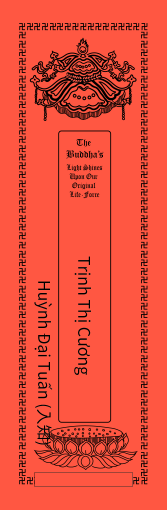

In [6]:



index=8
row=df.iloc[index]
    
canGenP1, p1Params=adapter(row["Beneficiary #1"], row["Sponsor"], row["Plaque #1"], row["Plaque#1 ID"])
p1Params
beneText=p1Params["beneText"]
beneTextLang=p1Params["beneTextLang"]
beneTextFont=p1Params["beneTextFont"]
# beneTextFont=englishBeneFont
sponsorText=p1Params["sponsorText"]
sponsorTextLang=p1Params["sponsorTextLang"]
sponsorTextFont=p1Params["sponsorTextFont"]

if beneText in ['zh', 'zh-Hant', 'ko']:
  beneText='\n'.join(beneText)

templatePath="/content/drive/MyDrive/plaqueGen/mmb_blank.png"

template = Image.open(templatePath)
canvas = ImageDraw.Draw(template)

# canvas.multiline_text((370, 1200), beneText, (0, 0, 0), font=beneTextFont, anchor='mm')

text_layer = Image.new("RGBA", (2550, 834), (255, 255, 255, 0))
textCanvas = ImageDraw.Draw(text_layer)

textCanvas.text((1280, 350), beneText, (0, 0, 0, 255), font=beneTextFont, anchor='mm')

textCanvas.text((1400, 550), sponsorText, (0, 0, 0, 255), font=sponsorTextFont, anchor='mm')
rotated_text_layer = text_layer.rotate(270.0, expand=1)

out = Image.alpha_composite(template, rotated_text_layer)
display(out.reduce(5))